In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import pandas as pd

%matplotlib inline

# example MATLAB implementation: 
# https://www.mathworks.com/matlabcentral/fileexchange/11721-simplified-fuzzy-artmap-neural-network

# Busque, Parizeau, A Comparison of Fuzzy ARTMAP and Multilayer Perceptron for Handwritten Digit Recognition,
# https://pdfs.semanticscholar.org/e3b5/1819aba022552dc284e6955ef1d888a2c41a.pdf

# Fuzzy ARTMAP

Se poate implementa $ART_b$ ca un vector $N_b$ dimensional, vezi observatia 5. din curs, paragraf 2, sectiunea 9.4.2

In [2]:
def load_dataset(file_name):
    """
    Returns x and y arrays
    """
    ...
    dataset = pd.read_csv(file_name, header=None, delimiter=' ').values
    return dataset[:, :-11], dataset[:, -11:-1]

In [3]:
x_set, y_set = load_dataset('semeion.data')
assert(x_set.shape[0] == 1593)
assert(x_set.shape[1] == 256)
assert(y_set.shape[0] == 1593)
assert(y_set.shape[1] == 10)

In [4]:
def show_sample(data, label):
    """
    Shows an instance as a 2D image
    """
    # Make those columns into a array of 8-bits pixels
    # The pixel intensity values are integers from 0 to 255
    pixels = np.array(data, dtype='uint8')

    # Reshape the array into 28 x 28 array (2-dimensional array)
    n = int(np.sqrt(len(pixels)))
    assert n**2 == len(pixels)
    pixels = pixels.reshape(n, n)

    # Plot
    plt.title('Label is {label}'.format(label=label))
    plt.imshow(pixels, cmap='gray')
    plt.show()

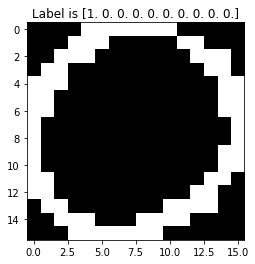

In [5]:
show_sample(x_set[1234], y_set[1234])

In [6]:
# for start, select only two classes, "0" and "1", and make the model work!
# (hint: it will train faster and with 100% accuracy)
classes = 10
indexes = np.isin( np.argmax(y_set, axis=1), [i for i in range(classes)])
x_train = x_set[ indexes ]
y_train = y_set[ indexes ]
assert(np.all([np.argmax(y_train[i]) < classes for i in range(y_train.shape[0])]))


In [7]:

# create a random ordering
perm = [i for i in range(x_train.shape[0])]
np.random.shuffle(perm)

# create the 70/30 train and test random partitions
seventies =int(x_train.shape[0] * 0.7)
x_test = x_train[seventies:]
y_test = y_train[seventies:]
x_train = x_train[:seventies]
y_train = y_train[:seventies]


# limit the length of the one-hot encoding to max classes
y_train = y_train[:, :classes]
y_test = y_test[:, :classes]

# enhance x_train by creating complement features
x_train = np.append(x_train, 1 - x_train, axis=1)
x_test = np.append(x_test, 1 - x_test, axis=1)

assert(x_train.shape[1] == 512)
assert(x_test.shape[1] == 512)
assert(y_train.shape[1] == classes)
assert(y_test.shape[1] == classes)

In [8]:
# since there are many variables, the recommended implementation method is to use a class
# 
# to learn to work with Python classes and static methods please see (two short articles):
# https://en.wikibooks.org/wiki/A_Beginner%27s_Python_Tutorial/Classes
# https://realpython.com/instance-class-and-static-methods-demystified/
#
class FuzzyArtMap:
    
    @staticmethod
    def max_with_inhibition(t, inhibited):
        """Finds j for an uninhibited node"""        
        t_copy = t.copy()
        t_copy[inhibited] = -1
        return np.argmax(t_copy)                


    def __init__(self, x_train, y_train):
        self.alpha_a = 0.001
        self.delta = 0.001
        self.rho_a = 0.5 #1.7 # ???
        self.rho_ab = 0.2
        self.beta_a = 1
        self.M_a = x_train.shape[1]
        self.N_a = 1 # reteaua pleaca cu 0 noduri
        self.N_b = y_train.shape[1]
        
        self.T0 = 0.1

        self.comitted = np.array([-1]) # e vectorul coloana de labeluri pt neuronii din F2a
        # neuronul necomis are label -1
        assert(self.comitted.shape[0] == self.N_a)

        self.w_a = np.ones((self.N_a, self.M_a))
        assert(np.all(self.w_a == 1))
        assert(self.w_a.shape == (self.N_a, self.M_a))

        self.w_ab = np.ones((self.N_a, self.N_b))
        assert(np.all(self.w_ab == 1))
        assert(self.w_ab.shape == (self.N_a, self.N_b))

    def train(self, x, y):
        inhibited = np.array([False for i in range(self.N_a)])
        assert(inhibited.shape[0] == self.N_a)
        
        # do the training
        rho = self.rho_a
        
        t = self.compute_activities(x)
        
        while True:
        
            j = self.max_with_inhibition(t, inhibited)

            if self.comitted[j] == -1: # is the neuron uncomitted?
                # create a new subclass
                self.w_a[j] = x
                self.comitted[j] = np.argmax(y)
                # create a new uncommitted neuron
                self.N_a += 1
                self.comitted = np.append(self.comitted, [-1])
                self.w_a = np.append(self.w_a, np.ones((1, self.M_a)), axis=0)
                
                break
            else:
                resonance = np.linalg.norm(np.minimum(x, self.w_a[j]), ord=1) / self.M_a
                if resonance < rho:
                    inhibited[j] = True
                    continue
                else:
                    if self.comitted[j] == np.argmax(y): # class match?
                        self.w_a[j] = self.beta_a * np.minimum(x, self.w_a[j]) + (1 - self.beta_a) * self.w_a[j]
                        break
                    else:
                        inhibited[j] = True
                        rho = resonance + self.delta
                        if rho > 1:
                            break
                    
        
    def compute_activities(self, x):
        numarator = np.linalg.norm(np.minimum(x, self.w_a), ord=1, axis=1)
        numitor = (self.alpha_a + np.linalg.norm(self.w_a, ord=1, axis=1))
        t = numarator / numitor
        t[-1] = self.T0
        return t
        # testing compute_activities
#         fam = FuzzyArtMap(x_train, y_train)
#         x = x_train[0]
#         y = y_train[0]
#         fam.w_a = np.append(fam.w_a, np.ones((fam.N_a, fam.M_a)), axis=0)
#         fam.w_a = np.append(fam.w_a, np.ones((fam.N_a, fam.M_a)), axis=0)
#         print(np.linalg.norm(np.minimum(x, fam.w_a), ord=1, axis=1))
#         print(x)
#         print(fam.compute_activities(x))


        
        
#     def ...(self, ...):
#         ...
#         return ...
    
    def compute_accuracy(self, x_test, y_test):
        correct = 0
        inhibited = np.array([False for i in range(self.N_a)])
        for i in range(x_test.shape[0]):
            x = x_test[i]
            y = y_test[i]
            t = self.compute_activities(x)
            j = self.max_with_inhibition(t, inhibited)
            if self.comitted[j] == np.argmax(y):
                correct += 1
                
        return correct / x_test.shape[0]

In [9]:
fam = FuzzyArtMap(x_train, y_train)

# assure you have correctly written the argmax function
assert(fam.max_with_inhibition(np.array([1, 2, 3, 4]), np.array([False, False, False, True])) == 2)
assert(fam.max_with_inhibition(np.array([1, 2, 3, 4]), np.array([False, False, True, False])) == 3)
assert(fam.max_with_inhibition(np.array([1, 2, 3]), np.array([False, True, True])) == 0)

In [10]:
x = x_train[0]
y = y_train[0]
fam.train(x, y)
print(x_train.shape)
#a = np.array([[1]])
#np.append(a, 1, axis=0)

(1115, 512)


In [11]:
epochs = 1
for i in range(epochs):
    for p in range(x_train.shape[0]):
        x = x_train[p]
        y = y_train[p]

        print("training %d of %d" % (p + 1, x_train.shape[0]))
        fam.train(x, y)

training 1 of 1115
training 2 of 1115
training 3 of 1115
training 4 of 1115
training 5 of 1115
training 6 of 1115
training 7 of 1115
training 8 of 1115
training 9 of 1115
training 10 of 1115
training 11 of 1115
training 12 of 1115
training 13 of 1115
training 14 of 1115
training 15 of 1115
training 16 of 1115
training 17 of 1115
training 18 of 1115
training 19 of 1115
training 20 of 1115
training 21 of 1115
training 22 of 1115
training 23 of 1115
training 24 of 1115
training 25 of 1115
training 26 of 1115
training 27 of 1115
training 28 of 1115
training 29 of 1115
training 30 of 1115
training 31 of 1115
training 32 of 1115
training 33 of 1115
training 34 of 1115
training 35 of 1115
training 36 of 1115
training 37 of 1115
training 38 of 1115
training 39 of 1115
training 40 of 1115
training 41 of 1115
training 42 of 1115
training 43 of 1115
training 44 of 1115
training 45 of 1115
training 46 of 1115
training 47 of 1115
training 48 of 1115
training 49 of 1115
training 50 of 1115
training 

training 397 of 1115
training 398 of 1115
training 399 of 1115
training 400 of 1115
training 401 of 1115
training 402 of 1115
training 403 of 1115
training 404 of 1115
training 405 of 1115
training 406 of 1115
training 407 of 1115
training 408 of 1115
training 409 of 1115
training 410 of 1115
training 411 of 1115
training 412 of 1115
training 413 of 1115
training 414 of 1115
training 415 of 1115
training 416 of 1115
training 417 of 1115
training 418 of 1115
training 419 of 1115
training 420 of 1115
training 421 of 1115
training 422 of 1115
training 423 of 1115
training 424 of 1115
training 425 of 1115
training 426 of 1115
training 427 of 1115
training 428 of 1115
training 429 of 1115
training 430 of 1115
training 431 of 1115
training 432 of 1115
training 433 of 1115
training 434 of 1115
training 435 of 1115
training 436 of 1115
training 437 of 1115
training 438 of 1115
training 439 of 1115
training 440 of 1115
training 441 of 1115
training 442 of 1115
training 443 of 1115
training 444 

training 788 of 1115
training 789 of 1115
training 790 of 1115
training 791 of 1115
training 792 of 1115
training 793 of 1115
training 794 of 1115
training 795 of 1115
training 796 of 1115
training 797 of 1115
training 798 of 1115
training 799 of 1115
training 800 of 1115
training 801 of 1115
training 802 of 1115
training 803 of 1115
training 804 of 1115
training 805 of 1115
training 806 of 1115
training 807 of 1115
training 808 of 1115
training 809 of 1115
training 810 of 1115
training 811 of 1115
training 812 of 1115
training 813 of 1115
training 814 of 1115
training 815 of 1115
training 816 of 1115
training 817 of 1115
training 818 of 1115
training 819 of 1115
training 820 of 1115
training 821 of 1115
training 822 of 1115
training 823 of 1115
training 824 of 1115
training 825 of 1115
training 826 of 1115
training 827 of 1115
training 828 of 1115
training 829 of 1115
training 830 of 1115
training 831 of 1115
training 832 of 1115
training 833 of 1115
training 834 of 1115
training 835 

In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 2 classes: 100.00%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 3 classes: 97.93%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 4 classes: 97.93%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 5 classes: 95.02%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 6 classes: 95.50%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 7 classes: 95.25%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 8 classes: 92.71%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 9 classes: 89.33%


In [12]:
print("Test accuracy on %d classes: %2.2f%%" % (classes, 100.0 * fam.compute_accuracy(x_test, y_test)))

Test accuracy on 10 classes: 85.56%


cross validation cu 90/10 pt clase si facuta media